## 1 Transforming Data
**The ratings.csv file contains user ratings, one movie per line. See the README file for more information. Transform the data into a user-movie
ratings matrix. There should be 610 rows (one for each user) and 9,742 columns (one for each movie). Each cell should contain the users rating forthat movie. Note that not every user has rated every movie. Assign a value of 0 for any missing values.**

In [1]:
import pandas as pd
import numpy as np

ratings = pd.read_csv("ml-latest-small/ratings.csv")
movies = pd.read_csv("ml-latest-small/movies.csv")
grouped = ratings.groupby(ratings['userId'])

userid = list(set(ratings['userId'].tolist()))
movieid = list(set(movies['movieId'].tolist()))
movieid.sort()

user_movie = pd.DataFrame()
for id in movieid:
    user_movie[id] = ''

for name, group in grouped:
    new_dict={}

    for i in range(len(group)):
        new_dict[group['movieId'].iloc[i]] = group['rating'].iloc[i]
        
    user_movie = user_movie.append(new_dict, ignore_index = True)
        
user_movie = user_movie.fillna(0)
user_movie.index = userid

## 2 Principle Component Analysis
**Apply PCA to the reduce the dimensionality of the movies.**

**(a) Transpose the matrix from Q1 so that rows refer to movies and columns refer to users. Mean center the data. Note that you will only use this
transformed, mean-centered data for this question.**

In [2]:
from sklearn import preprocessing
from sklearn import decomposition
import matplotlib.pyplot as plt

movie_user = user_movie.transpose()
movie_user_scaled = preprocessing.scale(movie_user, with_std=False)

**(b) Apply PCA with number of components k = 2 to reduce the dimensionality of the movies.**

In [3]:
pca = decomposition.PCA(n_components=2)
pca.fit(movie_user_scaled)
movie_user_trans = pca.transform(movie_user_scaled)

**(c) Plot the results and color each movies by its genre. Genres for each movie are listed in movies.csv. Since each movie may have more than one
genre, to simplify just use the first genre in the list. Discuss what patterns you see in the visualization.**

<ipython-input-5-c4d018e697d4>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies['genre1'][i] = first


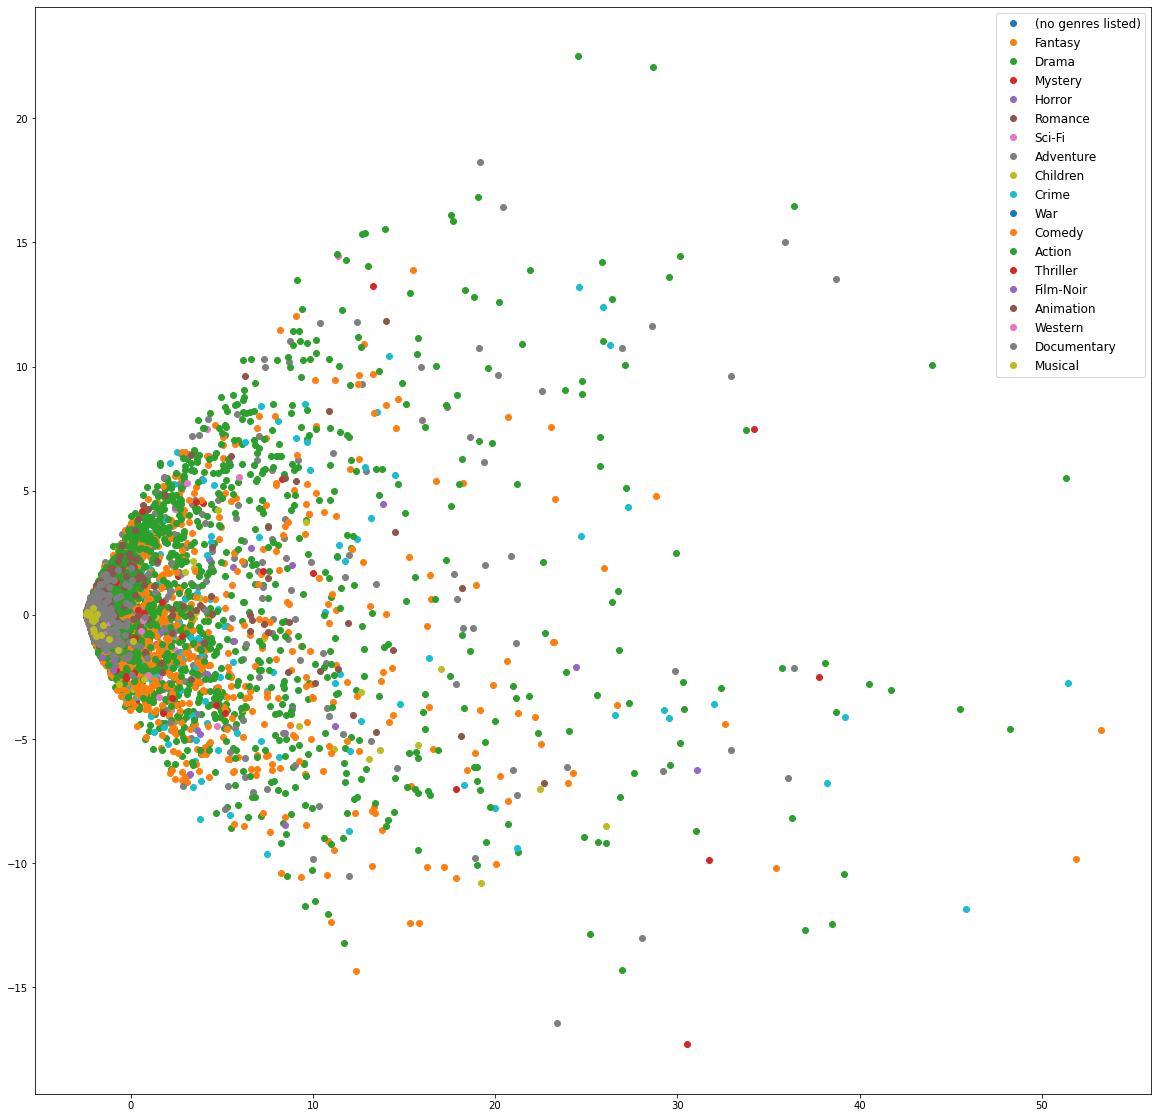

In [5]:
movies['genre1'] = ''
for i in range(len(movies)):
    try:
        first = movies['genres'][i].split('|')[0]
    except:
        first = movies['genres'][i]
        
    movies['genre1'][i] = first
        
genre = list(set(movies['genre1'].tolist()))
genre_dict = {}
for g in genre:
    genre_dict[g] = []
    
for i in range(len(movie_user_trans)):
    genre_dict[movies['genre1'].iloc[i]].append(list(movie_user_trans[i]))
    
plt.rcParams["figure.figsize"] = (20, 20)
fig, ax = plt.subplots()
for key in genre_dict.keys():
    now_array = np.array(genre_dict[key])
    ax.plot(now_array[:,0], now_array[:,1], marker='o', linestyle='', label=key)
    
ax.legend(fontsize=12, loc='upper right')

plt.show()

Genres are mixed together so we cannot tell differeces between genres. However, we can see that data are concentrated at (0, 0) and it spreads as x axis
increases.

**(d) Determine the "intrinsic" dimensionality of the movies, by finding the number of principle components that are needed to explain 80% of the
variance of the data. Discuss how this compares to k = 2 and how this may impact the quality of the visualization above**

In [6]:
pca = decomposition.PCA(n_components=610)
pca.fit(movie_user_scaled)
cumsum = np.cumsum(pca.explained_variance_ratio_)

d = np.argmax(cumsum >= 0.80) + 1
print("Dimension should be picked :", d)

Dimension should be picked : 153


Compared to k=2, k=153 will have more similar data with original data, and because of that, it will have less reconstruction error. But, in data visualization, it
will be very hard to show because of its number of demesions.

## 3 Clustering
**Apply k-means clustering to the data from Q1 (rows=users, columns=movies, no meancentering) and cluster the users.**

**(a) For values of k = [2, 4, 8, 16, 32], apply k-means and measure the inertia for each value of k. Plot the resulting inertia scores for each choice of k.**

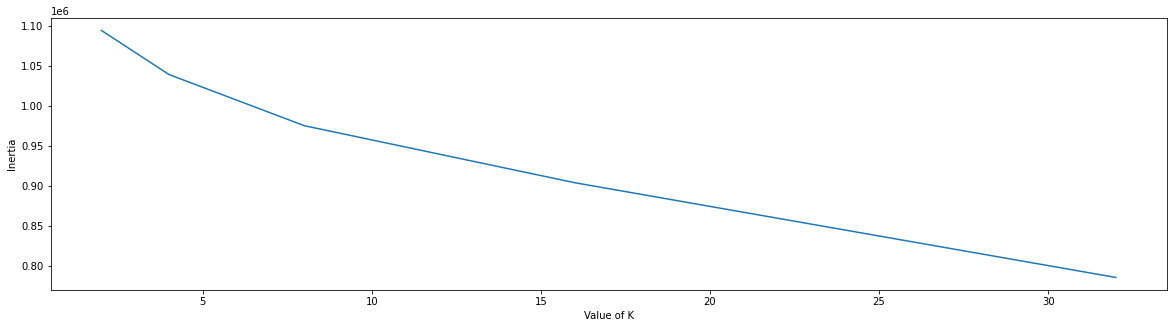

In [8]:
from sklearn.cluster import KMeans

k = [2, 4, 8, 16, 32]
inertia = []

for num in k:
    kmeans = KMeans(n_clusters=num)
    kmeans.fit(user_movie)
    inertia.append(kmeans.inertia_)
    
plt.rcParams["figure.figsize"] = (20, 5)
fig, bx = plt.subplots()
bx.plot(k, inertia)
plt.xlabel('Value of K')
plt.ylabel('Inertia')
plt.show()

**(b) From the above results, choose an appropriate value of k from the plot and support your choice.**

We can see 'elbow' of the plot when value of k is '4'. So we can pick '4' as appropriate value of k.

**(c) Cluster the data again with your chosen value of k. For each of the resulting clusters, find the top three movies that are highest rated (on
average) by the users in the cluster. Report the movie titles and discuss whether the results seem reasonable (i.e., do the top-rated movies in each
cluster seem to correspond to recognizable groups)**

In [9]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(user_movie)
y_kmeans = kmeans.predict(user_movie)

user_movie_nan = user_movie.replace(0, np.NaN)
user_movie_nan['cluster'] = y_kmeans
um_group = user_movie_nan.groupby(user_movie_nan['cluster']).mean()

max = um_group.idxmax(axis=1)

In [10]:
for mid in max:
    print(movies[movies['movieId']==mid]['title'].tolist()[0])

Lamerica (1994)
Smoke (1995)
Antonia's Line (Antonia) (1995)
Lamerica (1994)


They do not seem to be reasonable. They seem to have too little data so their average ratings are 5.0. So, it is selected.

## 4 Singular Value Decomposition
**Apply SVD to the user-movie matrix from Q1 (rows=users, columns=movies, no meancentering).**

**(a) Apply SVD with number of components k = 32. Plot the resulting singular values.**

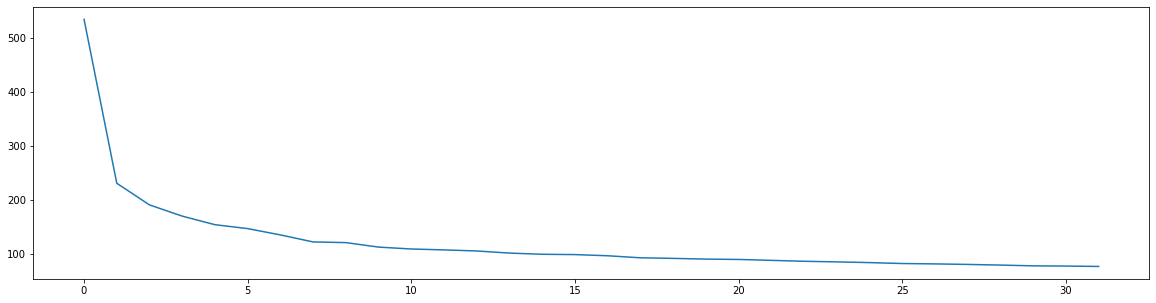

In [11]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components = 32)
svd.fit(user_movie)
S = svd.singular_values_

fig, cx = plt.subplots()
cx.plot(S)
plt.show()

**(b) For each of the values of k = [2, 4, 8, 16, 32] considered above, report the sum of the explained variance ratio. Discuss how the results compare
to the inertia values above and whether it supports your choice of k.**

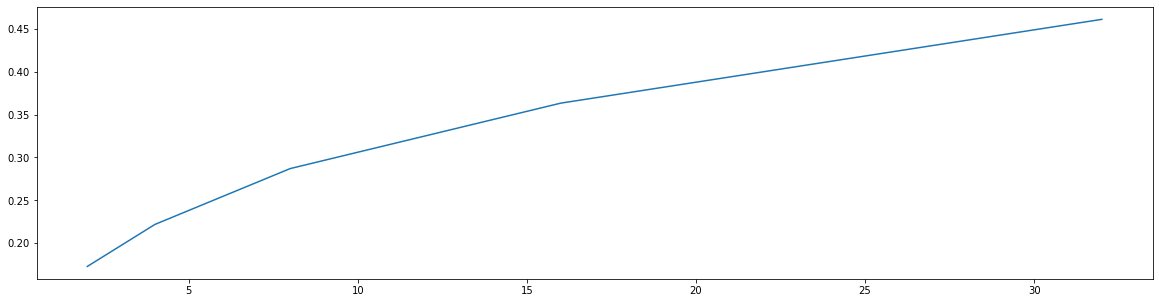

In [13]:
k = [2, 4, 8, 16, 32]
ratio = []
for num in k:
    svd = TruncatedSVD(n_components = num)
    svd.fit(user_movie)
    ratio.append(svd.explained_variance_ratio_.sum())
    
fig, dx = plt.subplots()
dx.plot(k, ratio)
plt.xlabel = "Number of Components"
plt.ylabel = "Explained Variance Ratio"
plt.show()

The graph shows exactly opposite tendency compared to graph above. As the number increases, explained variance ratio increases.
We can select k =4, which is elbow of the graph and graph above supports the selection as its elbow is also around 4.

**(c) Apply SVD with k = 2 and transform the data.**

In [15]:
svd = TruncatedSVD(n_components = 2)
trans= pd.DataFrame(svd.fit_transform(user_movie))
trans

,0,1
0,29.689244,-14.261064
1,3.135065,4.101266
2,0.723193,-0.478366
3,17.294912,-12.539916
4,6.097046,-5.338158
...,...,...
605,59.471262,-16.747952
606,20.832512,-11.700882
607,62.053858,-2.741634
608,4.050601,-3.187558


**(d) Plot the results (for k = 2) and color the users by the cluster memberships you found above. Discuss any patterns you can see and compare
them to the previous analysis (either from clustering or PCA).**

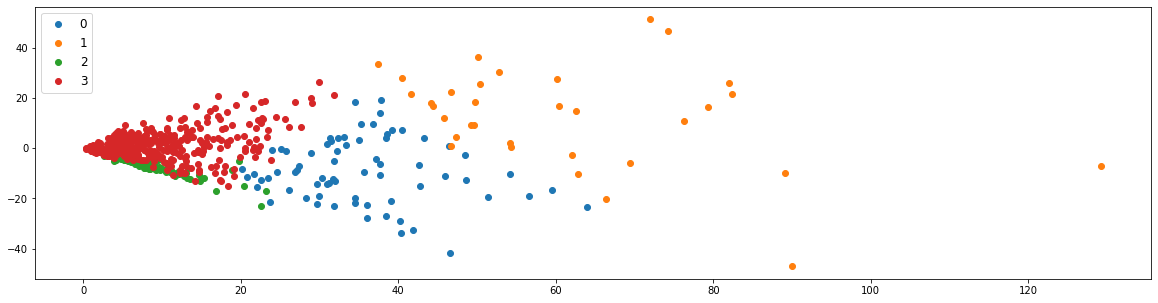

In [16]:
trans['cluster'] = y_kmeans
trans_group = trans.groupby('cluster')
fig, ex = plt.subplots()

for name, group in trans_group:
    ex.plot(group[0], group[1], marker='o', linestyle='', label=name)
ex.legend(fontsize=12, loc='upper left')

plt.show()

Comparing with PCA, the scatter points are concentrated at (0, 0) and it spreads as the x axis increases. And when we see the clusters, they are seperated
with some patterns.